In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import gcf

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
#from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3,get_indices_2ormore#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
#from mcmodels.regressors import NadarayaWatson
#from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache, 167587189)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

annotation/ccf_2017


In [7]:
connectivity_data = get_connectivity_data(cache, major_structure_ids[:12], experiments_exclude, remove_injection = False)

connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs

512
703
1089
1097
315
313
354
698
771
803
477
549


In [10]:
#load data
#there appears to be an issue with index_col = [0],  header=[0,1]
wt_conn = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/connectivities/ELLeafsmoothsummarysurface_leafsource_summarytarget_v3/elsummarymodel_leafsource_summarytarget_wt_v3.csv',  header=[0,1])

def fix_pdcsv(csv):
    
    #wt_conn = pd.read_csv('/Users/samsonkoelle/wt_leafsmooth_leafsurface_sumtarget.csv',  header=[0,1])
    csv_rownames = np.asarray(csv.iloc[:,0])
    csv = csv.iloc[:,1:]
    csv.index = csv_rownames
    return(csv)

wt_conn = fix_pdcsv(wt_conn)

ontological_order = get_ordered_summary_structures(cache,167587189)
#due to redundancy in ccfv3, remove 'MDRNv', 'MDRNd' from summary structures (include as leafs of MDRN)
ontological_order = ontological_order[~np.in1d(ontological_order,[1098, 1107])]
#np.save('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/ontological_order_summary', ontological_order)
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
ontological_order_names = np.asarray([ia_map[ontological_order[i]] for i in range(len(ontological_order))])
ontological_order_leaves_names = np.asarray([ia_map[ontological_order_leaves[i]] for i in range(len(ontological_order_leaves))])

contra_inds = np.where(np.asarray(list(wt_conn.columns))[:,0] == 'contra')[0]
ipsi_inds = np.where(np.asarray(list(wt_conn.columns))[:,0] == 'ipsi')[0]

contra_names = ontological_order_names[np.in1d(ontological_order_names,np.asarray(list(wt_conn.columns))[:,1][contra_inds])]

ipsi_names = ontological_order_names[np.in1d(ontological_order_names,np.asarray(list(wt_conn.columns))[:,1][ipsi_inds])]

icomb = np.asarray([np.repeat('ipsi',ipsi_names.shape[0]),ipsi_names])
icomb = np.asarray(icomb)
tuples2 = list(zip(*icomb))
ipsi_multi = pd.MultiIndex.from_tuples(tuples2, names=['first', 'second'])
#contra_inds = cnam_multi[~np.in1d(cnam_multi,wt_conn.columns)]

ccomb = np.asarray([np.repeat('contra',contra_names.shape[0]),contra_names])
ccomb = np.asarray(ccomb)
tuples2 = list(zip(*ccomb))
cnam_multi = pd.MultiIndex.from_tuples(tuples2, names=['first', 'second'])
#contra_multi = cnam_multi[~np.in1d(cnam_multi,wt_conn.columns)]

comb = np.hstack([icomb,ccomb])
tuples = list(zip(*comb))
multi = pd.MultiIndex.from_tuples(tuples, names=['first', 'second'])

In [11]:
#np.save('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/ontological_order_leaves_names', ontological_order_leaves_names)

In [12]:
#wt_conn_oo = wt_conn.loc[ontological_order_leaves_names].loc[:,multi]

In [13]:
from mcmodels.core import Mask
def get_regional_centroids(cache,sid,hemisphere_id):
    
    mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=hemisphere_id)
    centroid_loc = np.mean(mask.coordinates, axis = 0)
    
    return(centroid_loc)

regional_centroids_sources = np.asarray([get_regional_centroids(cache,ontological_order[i],hemisphere_id = 2) for i in range(len(ontological_order))])

# ipsi_names = np.asarray(list(wt_conn.columns))[:291][:,1]
# contra_names = np.asarray(list(wt_conn.columns))[291:][:,1]
regional_centroids_ipsitargets = np.asarray([get_regional_centroids(cache,ai_map[ipsi_names[i]],hemisphere_id = 2) for i in range(len(ipsi_inds))])
regional_centroids_contratargets = np.asarray([get_regional_centroids(cache,ai_map[contra_names[i]],hemisphere_id = 1) for i in range(len(contra_inds))])

#nreg = wt_conn_oo.shape[0]
#crow = np.zeros((nreg,4), dtype  =float)

  

# for i in range(nreg):
#     crow[i,:] = np.asarray(cs_col_ipsi_dict[major_ontoloogy[i]])

In [20]:
regional_centroids_targets = np.vstack([regional_centroids_ipsitargets,regional_centroids_contratargets])

ntarg = wt_conn.shape[1]
nsource = regional_centroids_sources.shape[0]
distances = np.zeros((nsource, ntarg))
for i in range(nsource):
    #print(i)
    for j in range(ntarg):
        distances[i,j] = np.linalg.norm(regional_centroids_sources[i] - regional_centroids_targets[j])

In [26]:
np.save('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/distances_summary_summary', distances)

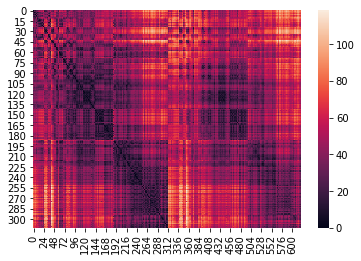

In [22]:
sns.heatmap(distances)

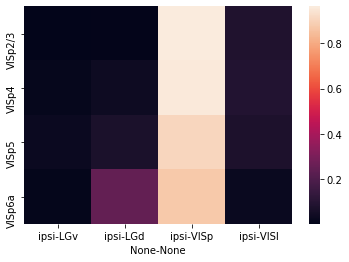

In [60]:
target_regions = [(  'ipsi',     'LGv'), (  'ipsi',     'LGd'),(  'ipsi',     'VISp'), (  'ipsi',     'VISl')]
sns.heatmap(wt_conn.loc[:,target_regions].loc[['VISp2/3', 'VISp4','VISp5','VISp6a']])

In [221]:
# #target_ordering= ontological_order_leaves

# #rnames = np.asarray([ia_map[ontological_order_leaves[i]] for i in range(len(ontological_order_leaves))])
# ipsi_target_regions = connectivity_data.ipsi_target_regions
# contra_target_regions = connectivity_data.contra_target_regions                               
# ipsi_indices= np.asarray([])
# contra_indices = np.asarray([])
# for iy in target_ordering: 
#     ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
#     contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
# ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
# contra_indices = np.asarray(contra_indices, dtype = int)    
# reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
# ntarget = len(reorder)

# colids = np.concatenate([ipsi_target_regions, contra_target_regions])[reorder]
# cnames = np.asarray([ia_map[colids[i]] for i in range(len(colids))])


# ccomb = np.vstack([np.concatenate([np.repeat('ipsi',connectivity_data.ipsi_target_regions.shape[0]),
#                                    np.repeat('contra',connectivity_data.contra_target_regions.shape)]), cnames])
# ccomb = np.asarray(ccomb)
# tuples2 = list(zip(*ccomb))
# cnam_multi = pd.MultiIndex.from_tuples(tuples2, names=['first', 'second'])

In [222]:
#wt_conn.loc[:,[('ipsi', 'TMv'), ('ipsi','IC')]]

In [223]:
#sns.heatmap(wt_conn[:,target_regions])

In [224]:
#sns.heatmap(wt_conn.loc['VISp2/3', :].loc[:,target_regions])

In [225]:
# ipsi_inds = np.where(np.asarray(list(wt_conn.columns))[:,0] == 'ipsi')[0]
# contra_inds = np.where(np.asarray(list(wt_conn.columns))[:,0] == 'contra')[0]

In [226]:
# ipsi_names = np.asarray(list(wt_conn.columns))[:,1][ipsi_inds]
# contra_names = np.asarray(list(wt_conn.columns))[:,1][contra_inds]

In [14]:
# from mcmodels.core import Mask
# def get_regional_centroids(cache,sid,hemisphere_id):
    
#     mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=hemisphere_id)
#     centroid_loc = np.mean(mask.coordinates, axis = 0)
    
#     return(centroid_loc)

# regional_centroids_sources = np.asarray([get_regional_centroids(cache,ai_map[wt_conn_oo.index[i]],hemisphere_id = 2) for i in range(len(wt_conn_oo.index))])

# # ipsi_names = np.asarray(list(wt_conn.columns))[:291][:,1]
# # contra_names = np.asarray(list(wt_conn.columns))[291:][:,1]
# regional_centroids_ipsitargets = np.asarray([get_regional_centroids(cache,ai_map[ipsi_names[i]],hemisphere_id = 2) for i in range(len(ipsi_inds))])
# regional_centroids_contratargets = np.asarray([get_regional_centroids(cache,ai_map[contra_names[i]],hemisphere_id = 1) for i in range(len(contra_inds))])

# nreg = wt_conn_oo.shape[0]
# crow = np.zeros((nreg,4), dtype  =float)

# regional_centroids_targets = np.vstack([regional_centroids_ipsitargets,regional_centroids_contratargets])

# ntarg = wt_conn_oo.shape[1]
# nsource = regional_centroids_sources.shape[0]
# distances = np.zeros((nsource, ntarg))
# for i in range(nsource):
#     #print(i)
#     for j in range(ntarg):
#         distances[i,j] = np.linalg.norm(regional_centroids_sources[i] - regional_centroids_targets[j])
        

# # for i in range(nreg):
# #     crow[i,:] = np.asarray(cs_col_ipsi_dict[major_ontoloogy[i]])

In [1]:
pd_dist = pd.DataFrame(distances, columns = wt_conn_oo.columns, index=wt_conn_oo.index)

NameError: name 'pd' is not defined

In [24]:
pd_dist.iloc[101,43]

79.2569675620158

In [241]:
pd_dist.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/distances.csv')

In [244]:
def get_aligned_ids(list1,list2):
    output = np.empty(len(list1), dtype = int)
    for i in range(len(list1)):
        output[ i] = np.intersect1d(st.ancestor_ids([list1[i]]), list2)[0]
    return(output)
eval_cres = ['C57BL/6J']
ontological_order_leaves_majors = get_aligned_ids(ontological_order_leaves,major_structure_ids)
ontological_order_leaves_summary = get_aligned_ids(ontological_order_leaves,ontological_order)


In [246]:
#major_ontoloogy_summary = np.load('/Users/samsonkoelle/ontological_order_summary_majors_names.npy')
ontological_order_leaves_majors_names = np.asarray([ia_map[ontological_order_leaves_majors[i]] for i in range(len(ontological_order_leaves_majors))])
ontological_order_summary_majors = get_aligned_ids(ontological_order,major_structure_ids)
ontological_order_summary_majors_names = np.asarray([ia_map[ontological_order_summary_majors[i]] for i in range(len(ontological_order_summary_majors))])

In [264]:
oos_ic = np.asarray([ai_map[comb[1][i]] for i in range(len(comb[1]))])

In [265]:
oos_ic_majors = get_aligned_ids(oos_ic,major_structure_ids)

In [276]:
oos_ic_major_names = np.asarray([ia_map[oos_ic_majors[i]] for i in range(len(oos_ic_majors))])

In [277]:
#np.save('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/ontological_order_summary_majors_names_v3', ontological_order_summary_majors_names)
np.save('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/oos_ic_majors_v3', oos_ic_major_names)
np.save('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/ool_majors_names_v3', ontological_order_leaves_majors_names)

In [237]:
cs_col_ipsi = sns.color_palette("Spectral", 12)
cs_col_contra = sns.color_palette("Spectral", 12)

alphad_ipsi_majors = np.hstack([np.asarray(cs_col_contra), np.expand_dims(np.ones(12),1)])
alphad_contra_majors = np.hstack([np.asarray(cs_col_contra), .02*np.expand_dims(np.ones(12),1)])

cs_col_ipsi = alphad_ipsi_majors
cs_col_contra = alphad_contra_majors

cs_col_ipsi_dict = {}
cs_col_contra_dict = {}
for i in range(12):
    cs_col_ipsi_dict[major_structures[i]] = cs_col_ipsi[i]
    cs_col_contra_dict[major_structures[i]] = cs_col_contra[i]

ccol = np.zeros((577,4), dtype  =float)

for i in range(291):
    ccol[i,:] = np.asarray(cs_col_ipsi_dict[major_ontoloogy_summary[i]])
    
for i in range(286):
    ccol[i+ 291] = np.asarray(cs_col_contra_dict[major_ontoloogy_summary[:286][i]])
    

(291,)

In [ ]:
# cs_col_ipsi = sns.color_palette("Spectral", 12)
# cs_col_contra = sns.color_palette("Spectral", 12)

# alphad_ipsi_majors = np.hstack([np.asarray(cs_col_contra), np.expand_dims(np.ones(12),1)])
# alphad_contra_majors = np.hstack([np.asarray(cs_col_contra), .02*np.expand_dims(np.ones(12),1)])

# cs_col_ipsi = alphad_ipsi_majors
# cs_col_contra = alphad_contra_majors

# cs_col_ipsi_dict = {}
# cs_col_contra_dict = {}
# for i in range(12):
#     cs_col_ipsi_dict[major_structures[i]] = cs_col_ipsi[i]
#     cs_col_contra_dict[major_structures[i]] = cs_col_contra[i]

# ccol = np.zeros((577,4), dtype  =float)

# for i in range(291):
#     ccol[i,:] = np.asarray(cs_col_ipsi_dict[major_ontoloogy_summary[i]])
    
# for i in range(286):
#     ccol[i+ 291] = np.asarray(cs_col_contra_dict[major_ontoloogy_summary[:286][i]])
    

In [234]:
# g= sns.clustermap(distances, col_cluster = False, row_cluster = False, col_colors=ccol, 
#                   row_colors = crow, figsize = (15,15), cmap = 'vlag')
# g.ax_heatmap.set_xticks([])
# g.ax_heatmap.set_yticks([])
# g.ax_heatmap.set_yticklabels([])
# g.ax_heatmap.set_xticklabels([])
# g.ax_heatmap.set_xlabel('Summary Target (n = 577)', fontsize = 30)
# g.ax_heatmap.set_ylabel('Leaf Source (n = 541)', fontsize = 30)
# #g.set_title('Source-target distances', fontsize = 40)
# ax = gcf().add_axes((0.6,1.,0.,0.))
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# for label in np.asarray(major_structures)[reo]:
#     ax.bar(0, 0, color=cs_col_ipsi_dict[label], label=label, linewidth=0.)
# l4 = ax.legend(title='Major Structure', ncol=2, bbox_to_anchor=(1.2, .5), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

# g.ax_cbar.set_xlabel('Distance b/w structures', rotation=0, fontsize = 20)
# g.ax_cbar.set_position([1.05,0.6,.1,.1])
# g.ax_col_colors.text(150.,.6, 'Ipsilateral', fontsize = 20)
# g.ax_col_colors.text(400.,.6, 'Contralateral', fontsize = 20)

# # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
# #             hspace = 0, wspace = 0)


NameError: name 'ccol' is not defined

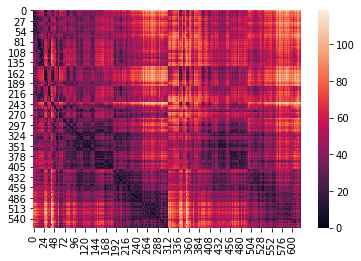

In [233]:
# sns.heatmap(distances)

In [27]:
#sns.heatmap(np.log(distances))

In [28]:
#seems bad....
regional_centroids_sources

array([[ 75.03773585,  66.81132075,  66.75471698],
       [104.0747331 ,  23.3594306 ,  69.69395018],
       [104.35454545,  18.53939394,  64.79545455],
       ...,
       [107.04166667,  46.04166667,  59.5       ],
       [ 96.11111111,  39.33333333,  60.55555556],
       [ 86.        ,  52.08333333,  60.        ]])

In [31]:
regional_centroids_targets

array([[ 75.03773585,  66.81132075,  66.75471698],
       [103.82194245,  21.30755396,  69.61915468],
       [101.81899642,  56.52329749,  77.57526882],
       ...,
       [107.        ,  46.04347826,  54.30434783],
       [ 96.25      ,  39.375     ,  53.25      ],
       [ 86.        ,  52.        ,  54.        ]])

In [32]:
distances

array([[ 0.        , 53.91964712, 30.66208868, ..., 40.09864466,
        37.21678691, 22.41047217],
       [52.34360571,  2.06874243, 34.16204909, ..., 27.56742761,
        24.2513589 , 37.32664282],
       [56.51099852,  5.58699014, 40.15631446, ..., 29.55564928,
        25.16155118, 39.66161035],
       ...,
       [38.83633656, 26.91728528, 21.53732138, ...,  5.19581956,
        14.14096934, 22.55002156],
       [35.17892181, 21.59940904, 24.85448575, ..., 14.23627565,
         7.30699447, 17.48297232],
       [19.56300208, 36.84153044, 24.05917711, ..., 22.58141499,
        17.66710888,  6.00057868]])

In [4]:
wt_conn = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/connectivities/elsummarymodel_leafsource_leaftarget_wt_v3_00401_l1norm.csv',  header=[0,1])

def fix_pdcsv(csv):
    
    #wt_conn = pd.read_csv('/Users/samsonkoelle/wt_leafsmooth_leafsurface_sumtarget.csv',  header=[0,1])
    csv_rownames = np.asarray(csv.iloc[:,0])
    csv = csv.iloc[:,1:]
    csv.index = csv_rownames
    return(csv)

wt_conn = fix_pdcsv(wt_conn)


In [8]:

ontological_order = get_ordered_summary_structures(cache,167587189)
#due to redundancy in ccfv3, remove 'MDRNv', 'MDRNd' from summary structures (include as leafs of MDRN)
#ontological_order[277]
ontological_order = ontological_order[~np.in1d(ontological_order,[1098, 1107])]
#ontological_order = np.setdiff1d(ontological_order, [1098, 1107])
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
ontological_order_names = np.asarray([ia_map[ontological_order[i]] for i in range(len(ontological_order))])
ontological_order_leaves_names = np.asarray([ia_map[ontological_order_leaves[i]] for i in range(len(ontological_order_leaves))])


In [9]:
ontological_order

array([      184,       985,       993,       353,       329,       337,
             345,       369,       361, 182305689,       378,      1057,
             677,      1011,      1002,      1027,      1018,       402,
             394,       409,       385,       425,       533, 312782574,
       312782628,        39,        48,       972,        44,       723,
             731,       746,       104,       111,       119,       894,
             879,       886, 312782546,       417,       541,       922,
             895,       507,       151,       159,       589,       814,
             961,       619,       639,       647,       788,       566,
             382,       423,       463,       726,       982,        19,
             918,       926,       843,      1037,      1084,       502,
       484682470, 589508447, 484682508,       583,       952,       966,
             131,       295,       319,       780,       672,        56,
             998,       754,       250,       258, 

In [6]:
ontological_order

array([      184,       985,       993,       353,       329,       337,
             345,       369,       361, 182305689,       378,      1057,
             677,      1011,      1002,      1027,      1018,       402,
             394,       409,       385,       425,       533, 312782574,
       312782628,        39,        48,       972,        44,       723,
             731,       746,       104,       111,       119,       894,
             879,       886, 312782546,       417,       541,       922,
             895,       507,       151,       159,       589,       814,
             961,       619,       639,       647,       788,       566,
             382,       423,       463,       726,       982,        19,
             918,       926,       843,      1037,      1084,       502,
       484682470, 589508447, 484682508,       583,       952,       966,
             131,       295,       319,       780,       672,        56,
             998,       754,       250,       258, 

In [12]:
contra_inds = np.where(np.asarray(list(wt_conn.columns))[:,0] == 'contra')[0]
ipsi_inds = np.where(np.asarray(list(wt_conn.columns))[:,0] == 'ipsi')[0]

contra_names = ontological_order_leaves_names[np.in1d(ontological_order_leaves_names,np.asarray(list(wt_conn.columns))[:,1][contra_inds])]

ipsi_names = ontological_order_leaves_names[np.in1d(ontological_order_leaves_names,np.asarray(list(wt_conn.columns))[:,1][ipsi_inds])]

icomb = np.asarray([np.repeat('ipsi',ipsi_names.shape[0]),ipsi_names])
icomb = np.asarray(icomb)
tuples2 = list(zip(*icomb))
ipsi_multi = pd.MultiIndex.from_tuples(tuples2, names=['first', 'second'])
#contra_inds = cnam_multi[~np.in1d(cnam_multi,wt_conn.columns)]

ccomb = np.asarray([np.repeat('contra',contra_names.shape[0]),contra_names])
ccomb = np.asarray(ccomb)
tuples2 = list(zip(*ccomb))
cnam_multi = pd.MultiIndex.from_tuples(tuples2, names=['first', 'second'])
#contra_multi = cnam_multi[~np.in1d(cnam_multi,wt_conn.columns)]

comb = np.hstack([icomb,ccomb])
tuples = list(zip(*comb))
multi = pd.MultiIndex.from_tuples(tuples, names=['first', 'second'])

In [1]:
ontological_order_leaves_names

NameError: name 'ontological_order_leaves_names' is not defined

In [13]:
wt_conn_oo = wt_conn.loc[ontological_order_leaves_names].loc[:,multi]

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


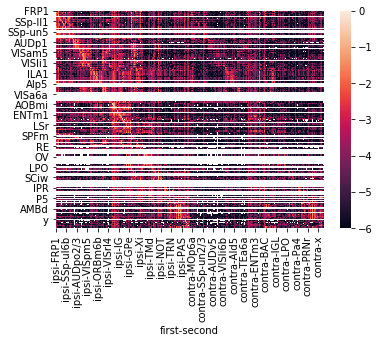

(564,)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


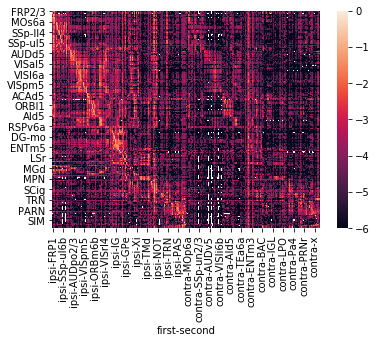

In [18]:


sns.heatmap(np.log10(wt_conn_oo.iloc[np.where(wt_conn_oo.sum(axis = 1) > 0)[0]]), vmin = -6, vmax = 0)

In [20]:
#data_sub = wt_conn_oo.iloc[np.where(wt_conn_oo.sum(axis = 1) > 0)[0]]

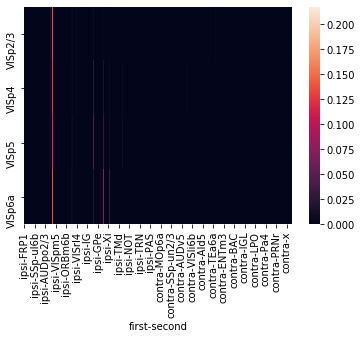

In [21]:
#sns.heatmap(data_sub.loc[:,].loc[['LGd','LGv','VISp2/3', 'VISp4','VISp5','VISp6a']])

In [61]:
target_regions = [(  'ipsi',     'LGd-co'), 
                  #(  'ipsi',     'VISp'), (  'ipsi',     'VISl'),
                 (  'ipsi',     'VISp2/3'), (  'ipsi',     'VISp4'),
                 (  'ipsi',     'VISp5'), (  'ipsi',     'VISp6a')]


In [39]:
target_regions = [(  'ipsi',     'LGd-co')]


In [34]:
np.where(np.asarray(list(data_sub.columns))[:,1] == 'LGd')

(array([], dtype=int64),)

In [38]:
np.asarray(list(data_sub.columns))[:500,1]

array(['FRP1', 'FRP2/3', 'FRP5', 'FRP6a', 'FRP6b', 'MOp1', 'MOp2/3',
       'MOp5', 'MOp6a', 'MOp6b', 'MOs1', 'MOs2/3', 'MOs5', 'MOs6a',
       'MOs6b', 'SSp-n1', 'SSp-n2/3', 'SSp-n4', 'SSp-n5', 'SSp-n6a',
       'SSp-n6b', 'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5',
       'SSp-bfd6a', 'SSp-bfd6b', 'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4',
       'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b', 'SSp-m1', 'SSp-m2/3', 'SSp-m4',
       'SSp-m5', 'SSp-m6a', 'SSp-m6b', 'SSp-ul1', 'SSp-ul2/3', 'SSp-ul4',
       'SSp-ul5', 'SSp-ul6a', 'SSp-ul6b', 'SSp-tr1', 'SSp-tr2/3',
       'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b', 'SSp-un1',
       'SSp-un2/3', 'SSp-un4', 'SSp-un5', 'SSp-un6a', 'SSp-un6b', 'SSs1',
       'SSs2/3', 'SSs4', 'SSs5', 'SSs6a', 'SSs6b', 'GU1', 'GU2/3', 'GU4',
       'GU5', 'GU6a', 'GU6b', 'VISC1', 'VISC2/3', 'VISC4', 'VISC5',
       'VISC6a', 'VISC6b', 'AUDd1', 'AUDd2/3', 'AUDd4', 'AUDd5', 'AUDd6a',
       'AUDd6b', 'AUDp1', 'AUDp2/3', 'AUDp4', 'AUDp5', 'AUDp6a', 'AUDp6b',
       'AUDpo1

In [51]:
source_regions = ['VISp2/3' ,'VISp4', 'VISp5','VISp6a','LGd-co']


In [56]:
data_sub.index
#LGd-sh', 'LGd-co', 'LGd-ip

(187,)

In [ ]:
target_regions

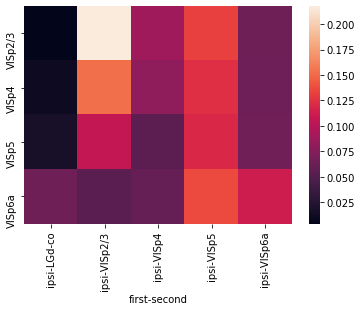

In [62]:
sns.heatmap(data_sub.loc[:,target_regions].loc[['VISp2/3', 'VISp4','VISp5','VISp6a']])

In [65]:
np.asarray(wt_conn.index)

array(['TMv', 'ICc', 'ICd', 'ICe', 'PSV', 'IF', 'PT', 'IG', 'AAA', 'IGL',
       'PVa', 'III', 'PVH', 'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a',
       'ACAd6b', 'ILA1', 'ILA2/3', 'ILA5', 'ILA6a', 'ILA6b', 'ACAv1',
       'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b', 'ACB', 'MT', 'IMD', 'PVHd',
       'AD', 'LT', 'ADP', 'DT', 'IO', 'AHN', 'IP', 'DCO', 'IPR', 'IPC',
       'IPA', 'IPL', 'IPI', 'IPDM', 'IPDL', 'IPRL', 'VCO', 'AId1',
       'AId2/3', 'AId5', 'AId6a', 'AId6b', 'ISN', 'AIp1', 'AIp2/3',
       'AIp5', 'AIp6a', 'AIp6b', 'IV', 'PVi', 'AIv1', 'AIv2/3', 'AIv5',
       'AIv6a', 'AIv6b', 'PVp', 'AMd', 'AMv', 'MRN', 'LA', 'PVpo', 'AMBd',
       'AMBv', 'IRN', 'PRNr', 'LC', 'PVT', 'AOBgl', 'AOBgr', 'AOBmi',
       'LD', 'AON', 'LDT', 'PRP', 'LGd-sh', 'LGd-co', 'LGd-ip', 'RCH',
       'NR', 'LGv', 'RE', 'FRP1', 'FRP2/3', 'FRP5', 'FRP6a', 'FRP6b',
       'LH', 'RH', 'LHA', 'RL', 'MV', 'LIN', 'RM', 'AP', 'LAV', 'LM',
       'RN', 'APN', 'SUV', 'LP', 'RO', 'ARH', 'SPIV', 'LPO', 'RPA', 'AT',
     

In [66]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)

In [79]:
major_structure_ids

[512, 703, 1089, 1097, 315, 313, 354, 698, 771, 803, 477, 549]

In [78]:
major_structures

['CB',
 'CTXsp',
 'HPF',
 'HY',
 'Isocortex',
 'MB',
 'MY',
 'OLF',
 'P',
 'PAL',
 'STR',
 'TH']

array([18, 32, 42, 54, 62, 67])

In [74]:
np.asarray([ia_map[leafs[315][i]] for i in range(len(leafs[315]))])

array(['RSPv2/3', 'VISp2/3', 'MOs5', ..., 'VISp4', 'SSp-bfd4', 'MOs5'],
      dtype='<U10')

In [77]:
np.asarray([ia_map[leafs[315][i]] for i in range(len(leafs[315]))])

array(['RSPv2/3', 'VISp2/3', 'MOs5', ..., 'VISp4', 'SSp-bfd4', 'MOs5'],
      dtype='<U10')

In [83]:
connectivity_data.creline[549][np.where(np.asarray([ia_map[leafs[549][i]] for i in range(len(leafs[549]))]) == 'LGd-co')[0]]

array(['Slc17a6-IRES-Cre', 'Slc17a6-IRES-Cre', 'Scnn1a-Tg2-Cre',
       'Scnn1a-Tg2-Cre', 'Scnn1a-Tg2-Cre', 'Scnn1a-Tg2-Cre'], dtype=object)